<a href="https://colab.research.google.com/github/LSowmyaDonepudi/Paraphrase-Identification/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the required libraries



In [ ]:
import numpy as np
from nltk import wordpunct_tokenize
import nltk
import itertools
import operator
import sklearn
import re, string
import math
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns


Define Functions for Data Pre-Processing

In [ ]:
# Define tokens
sentence_start_token = "sentence_start_token"
sentence_end_token = "sentence_end_token"
unknown_token = "unknown_token"  # for words not present in the vocabulary (unknown words)

# Function to load corpus
def load_data(loc='/content/'):
    "loading MSRP dataset"
    trainloc = loc + 'msr_paraphrase_train.txt'
    testloc = loc + 'msr_paraphrase_test.txt'

    sentence1_train, sentence2_train, sentence1_test, sentence2_test = [], [], [], []
    label_train, label_dev, label_test = [], [], []

    # Load training data
    with open(trainloc, 'r', encoding='utf8') as f:
        f.readline()  # skipping the header of the file
        for line in f:
            text = line.strip().split('\t')
            sentence1_train.append("%s %s %s" % (sentence_start_token, text[3], sentence_end_token))
            sentence2_train.append("%s %s %s" % (sentence_start_token, text[4], sentence_end_token))
            label_train.append(int(text[0]))

    # Load test data
    with open(testloc, 'r', encoding='utf8') as f:
        f.readline()  # skipping the header of the file
        for line in f:
            text = line.strip().split('\t')
            sentence1_test.append("%s %s %s" % (sentence_start_token, text[3], sentence_end_token))
            sentence2_test.append("%s %s %s" % (sentence_start_token, text[4], sentence_end_token))
            label_test.append(int(text[0]))

    return [sentence1_train, sentence2_train], [sentence1_test, sentence2_test], [label_train, label_test]

# Function to build dictionary
def build_dictionary(loc='/content/', vocabulary_size=-1):
    "load MSRP dataset and construct a dictionary"
    trainloc = loc + 'msr_paraphrase_train.txt'
    testloc = loc + 'msr_paraphrase_test.txt'

    document_frequency = {}
    total_document = 0

    # Process training data
    with open(trainloc, 'r', encoding='utf8') as f:
        f.readline()  # skipping the header of the file
        for line in f:
            text = line.strip().split('\t')
            sentence1 = my_tokenizer(text[3])
            sentence2 = my_tokenizer(text[4])

            for token in set(sentence1):
                if token in document_frequency:
                    document_frequency[token] = document_frequency[token] + 1
                else:
                    document_frequency[token] = 1

            for token in set(sentence2):
                if token in document_frequency:
                    document_frequency[token] = document_frequency[token] + 1
                else:
                    document_frequency[token] = 1

            total_document = total_document + 2

    # Process test data
    with open(testloc, 'r', encoding='utf8') as f:
        f.readline()  # skipping the header of the file
        for line in f:
            text = line.strip().split('\t')
            sentence1 = my_tokenizer(text[3])
            sentence2 = my_tokenizer(text[4])

            for token in set(sentence1):
                if token in document_frequency:
                    document_frequency[token] = document_frequency[token] + 1
                else:
                    document_frequency[token] = 1

            for token in set(sentence2):
                if token in document_frequency:
                    document_frequency[token] = document_frequency[token] + 1
                else:
                    document_frequency[token] = 1

            total_document = total_document + 2

    # Calculate IDF values
    for key, value in document_frequency.items():
        document_frequency[key] = math.log(total_document / document_frequency[key])

    # Sort vocabulary by IDF values
    vocab = sorted(document_frequency.items(), key=operator.itemgetter(1), reverse=True)

    # Create word-to-index and index-to-word mappings
    word_to_index = {}
    index_to_word = {}
    word_to_index[sentence_start_token] = 0
    word_to_index[sentence_end_token] = 1
    word_to_index[unknown_token] = 2
    index_to_word[0] = sentence_start_token
    index_to_word[1] = sentence_end_token
    index_to_word[2] = unknown_token

    counter = 3
    for key, value in vocab:
        if (len(key) < 4):
            continue
        elif counter == vocabulary_size:
            break
        word_to_index[key] = counter
        index_to_word[counter] = key
        counter = counter + 1

    return word_to_index, index_to_word

# Function to tokenize input sentences
def my_tokenizer(input):
    token_list = []
    tokens = wordpunct_tokenize(input.lower())
    token_list.extend([x for x in tokens if not re.fullmatch('[' + string.punctuation + ']+', x)])
    return token_list

# Function to get training data
def fetch_train_data(vocabulary_size):
    word_to_index, index_to_word = build_dictionary(vocabulary_size=vocabulary_size)
    [sentence1_train, sentence2_train], [sentence1_test, sentence2_test], [label_train, label_test] = load_data()

    # Tokenize and convert training sentences to indices
    sentence1_train_tokenized = [my_tokenizer(sent) for sent in sentence1_train]
    sentence2_train_tokenized = [my_tokenizer(sent) for sent in sentence2_train]

    for i, sent in enumerate(sentence1_train_tokenized):
        sentence1_train_tokenized[i] = [w if w in word_to_index else unknown_token for w in sent]
    for i, sent in enumerate(sentence2_train_tokenized):
        sentence2_train_tokenized[i] = [w if w in word_to_index else unknown_token for w in sent]

    sentence1_train_indices = []
    for sentence in sentence1_train_tokenized:
        sentence1_train_indices.append([word_to_index[word] for word in sentence])

    sentence2_train_indices = []
    for sentence in sentence2_train_tokenized:
        sentence2_train_indices.append([word_to_index[word] for word in sentence])

    return sentence1_train_indices, sentence2_train_indices, word_to_index, index_to_word, label_train

# Function to get test data
def fetch_test_data(vocabulary_size):
    word_to_index, index_to_word = build_dictionary(vocabulary_size=vocabulary_size)
    [sentence1_train, sentence2_train], [sentence1_test, sentence2_test], [label_train, label_test] = load_data()

    # Tokenize and convert test sentences to indices
    sentence1_test_tokenized = [my_tokenizer(sent) for sent in sentence1_test]
    sentence2_test_tokenized = [my_tokenizer(sent) for sent in sentence2_test]

    for i, sent in enumerate(sentence1_test_tokenized):
        sentence1_test_tokenized[i] = [w if w in word_to_index else unknown_token for w in sent]
    for i, sent in enumerate(sentence2_test_tokenized):
        sentence2_test_tokenized[i] = [w if w in word_to_index else unknown_token for w in sent]

    sentence1_test_indices = []
    for sentence in sentence1_test_tokenized:
        sentence1_test_indices.append([word_to_index[word] for word in sentence])

    sentence2_test_indices = []
    for sentence in sentence2_test_tokenized:
        sentence2_test_indices.append([word_to_index[word] for word in sentence])

    return sentence1_test_indices, sentence2_test_indices, word_to_index, index_to_word, label_test


Build a Bidirectional LSTM for Paraphrase Identification

In [ ]:
# Load data
sentence1_train_indices, sentence2_train_indices, word_to_index, _, label_train = fetch_train_data(vocabulary_size=5000)
sentence1_test_indices, sentence2_test_indices, _, _, label_test = fetch_test_data(vocabulary_size=5000)

# Pad sequences to the same length
max_sequence_length = max(max(len(seq) for seq in sentence1_train_indices),
                         max(len(seq) for seq in sentence2_train_indices))

sentence1_train_padded = pad_sequences(sentence1_train_indices, maxlen=max_sequence_length, padding='post')
sentence2_train_padded = pad_sequences(sentence2_train_indices, maxlen=max_sequence_length, padding='post')

sentence1_test_padded = pad_sequences(sentence1_test_indices, maxlen=max_sequence_length, padding='post')
sentence2_test_padded = pad_sequences(sentence2_test_indices, maxlen=max_sequence_length, padding='post')

# Model architecture
embedding_dim = 50

# Shared embedding layer
embedding_layer = Embedding(input_dim=len(word_to_index), output_dim=embedding_dim, input_length=max_sequence_length)

# Siamese network
input_sentence1 = Input(shape=(max_sequence_length,), name='input_sentence1')
input_sentence2 = Input(shape=(max_sequence_length,), name='input_sentence2')

# Apply the embedding layer to the input sequences
embedded_sentence1 = embedding_layer(input_sentence1)
embedded_sentence2 = embedding_layer(input_sentence2)

# Use Bidirectional LSTM layers in a deep architecture
lstm_layer1 = Bidirectional(LSTM(100, return_sequences=True))
lstm_layer2 = Bidirectional(LSTM(50, return_sequences=False))

# Apply the first LSTM layer
output_sentence1 = lstm_layer1(embedded_sentence1)
output_sentence2 = lstm_layer1(embedded_sentence2)

# Apply the second LSTM layer
output_sentence1 = lstm_layer2(output_sentence1)
output_sentence2 = lstm_layer2(output_sentence2)

# Concatenate the outputs and pass through a Dense layer
merged_output = concatenate([output_sentence1, output_sentence2], name='merged_output')
dense_layer = Dense(64, activation='relu', name='dense_layer')(merged_output)
output_layer = Dense(1, activation='sigmoid', name='output_layer')(dense_layer)

model = Model(inputs=[input_sentence1, input_sentence2], outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
X_train = { 'input_sentence1': sentence1_train_padded, 'input_sentence2': sentence2_train_padded }
X_test = { 'input_sentence1': sentence1_test_padded, 'input_sentence2': sentence2_test_padded }
y_train = np.array(label_train)
y_test = np.array(label_test)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
64/64 [==============================] - 51s 505ms/step - loss: 0.6319 - accuracy: 0.6681 - val_loss: 0.6260 - val_accuracy: 0.6649
Epoch 2/20
64/64 [==============================] - 27s 428ms/step - loss: 0.6183 - accuracy: 0.6752 - val_loss: 0.6171 - val_accuracy: 0.6649
Epoch 3/20
64/64 [==============================] - 28s 442ms/step - loss: 0.6073 - accuracy: 0.6769 - val_loss: 0.6066 - val_accuracy: 0.6754
Epoch 4/20
64/64 [==============================] - 29s 461ms/step - loss: 0.6018 - accuracy: 0.6820 - val_loss: 0.6058 - val_accuracy: 0.6696
Epoch 5/20
64/64 [==============================] - 29s 458ms/step - loss: 0.5354 - accuracy: 0.7353 - val_loss: 0.6917 - val_accuracy: 0.6586
Epoch 6/20
64/64 [==============================] - 27s 421ms/step - loss: 0.4523 - accuracy: 0.7897 - val_loss: 0.6326 - val_accuracy: 0.6707
Epoch 7/20
64/64 [==============================] - 29s 450ms/step - loss: 0.4086 - accuracy: 0.8184 - val_loss: 0.6483 - val_accuracy: 0.6597

Exploring the effect of Regularization

In [ ]:
# Model architecture with L2 regularization
embedding_dim = 50
l2_lambda = 0.01

# Shared embedding layer
embedding_layer = Embedding(input_dim=len(word_to_index), output_dim=embedding_dim, input_length=max_sequence_length)

# Siamese network
input_sentence1 = Input(shape=(max_sequence_length,), name='input_sentence1')
input_sentence2 = Input(shape=(max_sequence_length,), name='input_sentence2')

# Apply the embedding layer to the input sequences
embedded_sentence1 = embedding_layer(input_sentence1)
embedded_sentence2 = embedding_layer(input_sentence2)

# Use Bidirectional LSTM layers with L2 regularization
lstm_layer1 = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(l2_lambda)))
lstm_layer2 = Bidirectional(LSTM(50, return_sequences=False, kernel_regularizer=l2(l2_lambda)))

# Apply the first LSTM layer
output_sentence1 = lstm_layer1(embedded_sentence1)
output_sentence2 = lstm_layer1(embedded_sentence2)

# Apply the second LSTM layer
output_sentence1 = lstm_layer2(output_sentence1)
output_sentence2 = lstm_layer2(output_sentence2)

# Concatenate the outputs and pass through a Dense layer
merged_output = concatenate([output_sentence1, output_sentence2], name='merged_output')
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda), name='dense_layer')(merged_output)
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda), name='output_layer')(dense_layer)

model_regularized = Model(inputs=[input_sentence1, input_sentence2], outputs=output_layer)

# Compile the model
model_regularized.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_regularized = model_regularized.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/20
64/64 [==============================] - 47s 471ms/step - loss: 1.1461 - accuracy: 0.6754 - val_loss: 0.6467 - val_accuracy: 0.6649
Epoch 2/20
64/64 [==============================] - 27s 418ms/step - loss: 0.6347 - accuracy: 0.6754 - val_loss: 0.6401 - val_accuracy: 0.6649
Epoch 3/20
64/64 [==============================] - 27s 423ms/step - loss: 0.6337 - accuracy: 0.6754 - val_loss: 0.6405 - val_accuracy: 0.6649
Epoch 4/20
64/64 [==============================] - 27s 427ms/step - loss: 0.6323 - accuracy: 0.6754 - val_loss: 0.6385 - val_accuracy: 0.6649
Epoch 5/20
64/64 [==============================] - 27s 420ms/step - loss: 0.6317 - accuracy: 0.6754 - val_loss: 0.6386 - val_accuracy: 0.6649
Epoch 6/20
64/64 [==============================] - 28s 440ms/step - loss: 0.6316 - accuracy: 0.6754 - val_loss: 0.6385 - val_accuracy: 0.6649
Epoch 7/20
64/64 [==============================] - 27s 425ms/step - loss: 0.6322 - accuracy: 0.6754 - val_loss: 0.6388 - val_accuracy: 0.6649

Conclusion: Regularization is not necessary for this corpus.

Plot the results

54/54 [==============================] - 6s 52ms/step


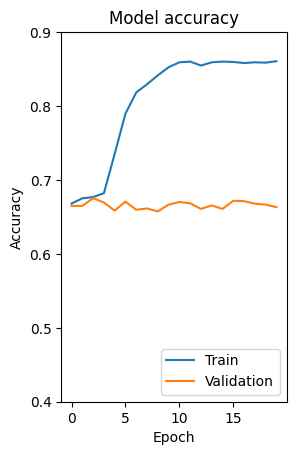

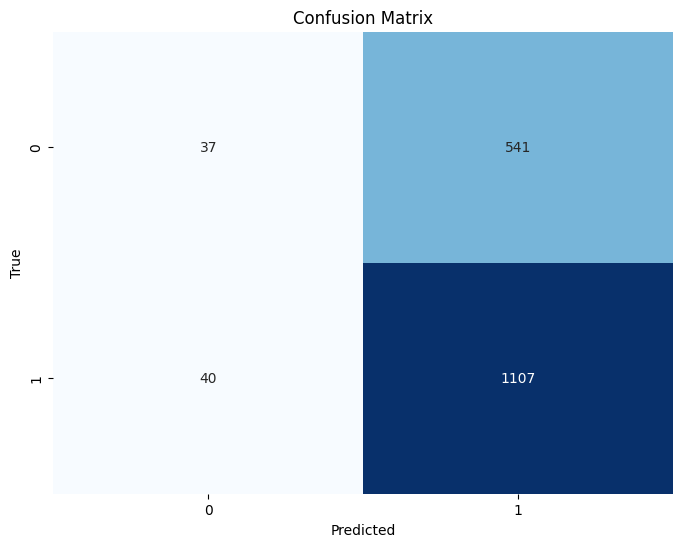

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.06      0.11       578
           1       0.67      0.97      0.79      1147

    accuracy                           0.66      1725
   macro avg       0.58      0.51      0.45      1725
weighted avg       0.61      0.66      0.56      1725



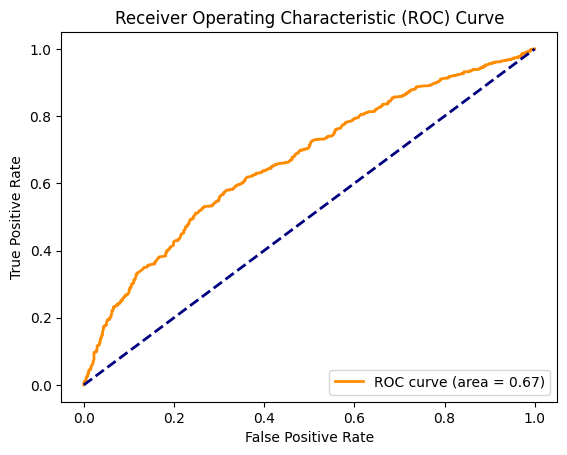

In [ ]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0.4, 0.9])

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
!jupyter nbconvert --to rst NLPFinal.ipynb

[NbConvertApp] Converting notebook NLPFinal.ipynb to rst
[NbConvertApp] Support files will be in NLPFinal_files/
[NbConvertApp] Making directory NLPFinal_files
[NbConvertApp] Making directory NLPFinal_files
[NbConvertApp] Making directory NLPFinal_files
[NbConvertApp] Writing 21925 bytes to NLPFinal.rst
